# Analysis of the largest comebacks in the NBA, 1996-2017

https://github.com/Jonathan-LeRoux/NBAcomebacks

#### Install statsnba-playbyplay module to download and parse play-by-play data from http://stats.nba.com 
More details here: [https://github.com/ethanluoyc/statsnba-playbyplay]

In [ ]:
import sys; sys.executable
!{sys.executable} -m pip install statsnba-playbyplay

In `path_to_your_python_installation/lib/site-packages/statsnba/__init__.py`, comment out the following line:
    #from .models import Game

In [ ]:
from __future__ import division
from statsnba.api import Api
import sys
import os
import pandas as pd
import time
import cPickle
import numpy as np
import plotly
import plotly.plotly as py
from plotly import tools
import plotly.graph_objs as go
plotly.offline.init_notebook_mode()
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.ticker 
%matplotlib nbagg
import seaborn as sns

In [4]:
api = Api()

In [5]:
def str2diff(s):
    scores = s[0].split(" - ")
    return int(scores[1]) - int(scores[0])
def abs_time(s):
    ftr = [60,1]
    return (s[1])*12*60 - sum([a*b for a,b in zip(ftr, map(int,s[2].split(':')))])
def get_score_times(data):
    return [ (x['SCORE'], x['PERIOD'],x['PCTIMESTRING'],x['GAME_ID']) for x in data['resultSets']['PlayByPlay'] if x['SCORE'] is not None]
def season_string(seasonstart):
    thisseason=int(seasonstart)
    nextseason=thisseason+1
    return str(thisseason)+"-"+str(nextseason)[2:]

## Download the data

In [6]:
years=range(1996,2017)
redo_download = False
if redo_download:
    score_times_season={}
    for seasonstart in years:
        season = season_string(seasonstart)
        score_times_season[season]={}
        ids=sorted(api.GetSeasonGameIDs(season,'Regular Season'))
        progress = 0
        num_games= len(ids)
        print "Retrieving ", num_games, " for season ", season
        for game_id in ids:
            if game_id not in score_times_season[season]:
                this_game_data =api.GetPlayByPlay(game_id)
                score_times_season[season][game_id] = get_score_times(this_game_data)
                time.sleep(.25)
            progress = progress + 1
            sys.stdout.write("Progress: %.1f%%   \r" % (progress/ num_games * 100) )
            sys.stdout.flush()
        with open("data/score_data_" + season + "_complete.p","wb") as fid:
            cPickle.dump(score_times_season[season],fid)

## Functions to compute the largest comebacks

In [7]:
def make_dic_from_data(data):
    # create a dictionary with time as key and score margin as value, 
    # keeping the maximum score margin if there are several for a given time.
    # By maximum, we mean the one most opposed to the final score (largest comeback)
    outcome = np.sign(str2diff(data[-1]))
    outdict = {}
    for s in data:
        thiskey = abs_time(s)
        scorediff=str2diff(s) 
        gameid = s[3]
        #if scorediff * outcome <= 0:
        if thiskey in outdict:
            if outcome*(scorediff - outdict[thiskey][0]) < 0: 
                # e.g., outcome = -1; scorediff=2, outdict[thiskey]=1: new largest comeback
                # or: outcome = 1; scorediff=-2, outdict[thiskey]=-1: new largest comeback
                outdict[thiskey] = (scorediff,set([gameid]))
        else:
            outdict[thiskey] = (scorediff,set([gameid]))
    outdict[0] = (0,set([gameid])) # adding the starting score margin
    return outdict

In [8]:
import heapq
import copy
def merge_comebacks(maindic,newdic,outcome):
    mainkeys = sorted(maindic.keys())
    newkeys  = sorted(newdic.keys())
    allkeys = heapq.merge(mainkeys,newkeys)
    current_largest = (0,set([]))
    main_is_largest = False
    for t in allkeys:
        if t in maindic:
            if outcome*(maindic[t][0] - current_largest[0]) <= 0 or main_is_largest:
                # main is either the new largest, or was already the largest but is moving to a different score (possibly smaller)
                if maindic[t][0] == current_largest[0]: #add maindic[t][1] to current_largest[1]
                    maindic[t] = (maindic[t][0],set(maindic[t][1].union(current_largest[1])))
                current_largest = (maindic[t][0],set(maindic[t][1]))
                main_is_largest = True
            else: # whoever was the current largest should overwrite main's value
                maindic[t] = copy.deepcopy(current_largest)
        if t in newdic:
            if main_is_largest:
                if outcome*(newdic[t][0] - current_largest[0]) < 0:
                    maindic[t] = copy.deepcopy(newdic[t])
                    current_largest = copy.deepcopy(newdic[t])
                    main_is_largest = False
                elif newdic[t][0] == current_largest[0]:
                    maindic[t] = (current_largest[0],set(current_largest[1].union(newdic[t][1])))
                    current_largest = copy.deepcopy(maindic[t])
                    main_is_largest = False # to give a chance to newdic at next index
                else: # remove new from main if it was in there
                    if t in maindic:
                        maindic[t] = (maindic[t][0],set(maindic[t][1].difference(newdic[t][1])))
                    current_largest = (current_largest[0],set(current_largest[1].difference(newdic[t][1])))
            else: # largest entry was from newdic, whatever this new score, it is the new largest at this time point
                maindic[t] = copy.deepcopy(newdic[t])
                current_largest = copy.deepcopy(newdic[t])

In [9]:
def check_data_valid(game_data):
    if len(game_data) > 0:
        first_score=game_data[0][0].split(' - ')
        return int(first_score[0])==0 or int(first_score[1])==0
    else:
        return False

In [10]:
total_time=6000
total_time_show=4*12*60+10
def full_score(sdic):
    s = np.zeros((total_time,))
    skeys = sorted(sdic.keys())
    for i in range(len(skeys)-1):
        tstart = skeys[i]
        tend   = skeys[i+1]
        margin = sdic[skeys[i]][0]
        s[tstart:tend] = margin
    return s
def full_list(sdic):
    s = []
    skeys = sorted(sdic.keys())
    if skeys[0] > 0:
        list_elem = sdic[skeys[0]][0]
        s.extend([list_elem] * (skeys[0]))
    for i in range(len(skeys)-1):
        tstart = skeys[i]
        tend   = skeys[i+1]
        list_elem = sdic[skeys[i]][0]
        s.extend([list_elem] * (tend-tstart))
    return s
def add_score_counts(S,sdic):
    N,T=S.shape
    C=int(N/2) # center score = 0
    skeys = sorted(sdic.keys())
    for i in range(len(skeys)-1):
        tstart = skeys[i]
        tend   = skeys[i+1]
        margin = sdic[skeys[i]][0]
        #print tstart, tend, margin
        S[C+margin,tstart:tend] = S[C+margin,tstart:tend] + 1
    return S

## Compute the largest comebacks for each season

In [11]:
years=range(1996,2017)
comebacks={}
for seasonstart in years:
    season = season_string(seasonstart)
    with open("data/score_data_"+season+"_complete.p","rb") as fid:
        seasonscores=cPickle.load(fid)
    ids = sorted(seasonscores.keys())

    comebacks[season]={}
    comebacks[season][1]={}
    comebacks[season][-1]={}

    for i in range(len(ids)):
        if check_data_valid(seasonscores[ids[i]]):
            outcome = np.sign(str2diff(seasonscores[ids[i]][-1]))
            merge_comebacks(comebacks[season][outcome],make_dic_from_data(seasonscores[ids[i]]),outcome)
        else:
            print "data for game ", ids[i], " appears invalid"
with open('data/comebacks_1996-2016_complete.p','wb') as f:
    cPickle.dump(comebacks,f)

data for game  0029600021  appears invalid
data for game  0029700144  appears invalid
data for game  0029700804  appears invalid
data for game  0029701131  appears invalid
data for game  0020000814  appears invalid
data for game  0020001001  appears invalid
data for game  0020001072  appears invalid
data for game  0020200216  appears invalid
data for game  0020200222  appears invalid
data for game  0021201214  appears invalid


### List of games with wrong stats:
* reverse order play-by-play
  * [http://stats.nba.com/game/#!/0029600021/playbyplay/]
  * [http://stats.nba.com/game/#!/0029700144/playbyplay/]
  * [http://stats.nba.com/game/#!/0029700804/playbyplay/]
  * [http://stats.nba.com/game/#!/0020000814/playbyplay/]
  * [http://stats.nba.com/game/#!/0020001001/playbyplay/]
  * [http://stats.nba.com/game/#!/0020001072/playbyplay/]
  * [http://stats.nba.com/game/#!/0020200216/playbyplay/]
  * [http://stats.nba.com/game/#!/0020200222/playbyplay/] 
* empty stats
  * [http://stats.nba.com/game/#!/0021201214/playbyplay/]   
* score does not start at 0-0
  * [http://stats.nba.com/game/#!/0029701131/playbyplay/]

## Plot the largest comebacks for every NBA season from 1996-97 to 2016-17

### Using subplots: nice, but too wide for a blog 

In [ ]:
with open('data/comebacks_1996-2016_complete.p','rb') as f:
    comebacks=cPickle.load(f)
years=range(1996,2017)
palette={y:p for y,p in zip(years,sns.husl_palette(len(years), h=.7).as_hex())}
traces={}
fig = tools.make_subplots(rows=1, cols=2, subplot_titles=('Home eventually wins', 'Away eventually wins'))
show_legend_outcome={-1:False,1:True}
for outcome in [-1,1]:
    traces[outcome]=[]
for seasonstart in years:
    season = season_string(seasonstart)
    for outcome in [-1,1]:
        traces[outcome].append(go.Scatter(
            x = np.arange(total_time_show)/60,
            y = outcome*full_score(comebacks[season][outcome])[:total_time_show],
            mode = 'lines',
            line = dict(width=2,color = palette[seasonstart]),
            name = season,showlegend=show_legend_outcome[outcome]))
    fig.append_trace(traces[1][-1], 1, 1)
    fig.append_trace(traces[-1][-1], 1, 2)

xtexts=[0,'<br>Q1',12,'<br>Q2',24,'<br>Q3',36,'<br>Q4',48]
xvals = [q*6 for q in range(len(xtexts))]
fig['layout']['xaxis1'].update(ticktext=xtexts,tickvals=xvals, title='Time (minutes)')
fig['layout']['xaxis2'].update(ticktext=xtexts,tickvals=xvals, title='Time (minutes)')
fig['layout']['yaxis1'].update(title='Largest comeback score')
fig['layout']['yaxis2'].update(title='Largest comeback score')

fig['layout'].update(height=800, width=1000, 
                     title='Largest comebacks for every NBA season from 1996-97 to 2016-17')
plotly.offline.iplot(fig, filename='largest_comebacks_by_season_1996_2016')
# if you have a plotly account, this command will push the figure to it
#py.plot(fig, filename='largest_comebacks_by_season_1996_2016')

#### Output of the previous cell is large, you can check it online here:
[https://plot.ly/~jonl/12]

### Using separate plots, tweaking the size to fit the Wordpress theme 

In [ ]:
with open('data/comebacks_1996-2016_complete.p','rb') as f:
    comebacks=cPickle.load(f)
years=range(1996,2017)
palette={y:p for y,p in zip(years,sns.husl_palette(len(years), h=.7).as_hex())}
traces={}
layouts={}
titles = {1:'Home eventually wins', -1:'Away eventually wins'}
title_suffix={1:'_home',-1:'_away'}
show_legend_outcome={-1:True,1:True}
for outcome in [-1,1]:
    traces[outcome]=[]
    layouts[outcome]=go.Layout()
for seasonstart in years:
    season = season_string(seasonstart)
    for outcome in [-1,1]:
        traces[outcome].append(go.Scatter(
            x = np.arange(total_time_show)/60,
            y = outcome*full_score(comebacks[season][outcome])[:total_time_show],
            mode = 'lines',
            line = dict(width=2,color = palette[seasonstart]),
            name = season,showlegend=show_legend_outcome[outcome]))
xtexts=[0,'<br>Q1',12,'<br>Q2',24,'<br>Q3',36,'<br>Q4',48]
xvals = [q*6 for q in range(len(xtexts))]
for outcome in [1,-1]:
    layouts[outcome]['xaxis'].update(ticktext=xtexts,tickvals=xvals, title='Time (minutes)')
    layouts[outcome]['yaxis'].update(title='Largest comeback score')
    
    layouts[outcome].update(height=800, width=540, 
                         title='Largest comebacks for every NBA season<br>from 1996-97 to 2016-17 ('+titles[outcome]+')')
    plotly.offline.iplot(go.Figure(data=traces[outcome], layout=layouts[outcome]), filename='largest_comebacks_by_season_1996_2016'+title_suffix[outcome])
    # if you have a plotly account, this command will push the figure to it
    #py.plot(go.Figure(data=traces[outcome], layout=layouts[outcome]), filename='largest_comebacks_by_season_1996_2016_wp'+title_suffix[outcome])

#### Output of the previous cell is large, you can check it online here:

[https://plot.ly/~jonl/16]

[https://plot.ly/~jonl/18]

## Compute the largest comebacks across all seasons

In [12]:
years=range(1996,2017)
with open('data/comebacks_1996-2016_complete.p','rb') as f:
    comebacks=cPickle.load(f)
overall_comebacks={}
for seasonstart in years:
    season = season_string(seasonstart)
    for outcome in [-1,1]:
        if outcome not in overall_comebacks:
            overall_comebacks[outcome]=copy.deepcopy(comebacks[season][outcome])
        else:
            merge_comebacks(overall_comebacks[outcome],comebacks[season][outcome],outcome)
with open('data/overall_comebacks_1996-2016.p','wb') as f:
    cPickle.dump(overall_comebacks,f)

In [13]:
game_info_dict={}
def get_info(gid,show_attendance=False):
    if gid not in game_info_dict:
        bb=api.GetBoxscoreSummary(gid)
        game_info_dict[gid] = {}
        game_info_dict[gid]['time']  = bb['resultSets']['GameInfo'][0]['GAME_DATE']
        game_info_dict[gid]['crowd'] = str(bb['resultSets']['GameInfo'][0]['ATTENDANCE'])
        game_info_dict[gid]['home'] = ' '.join([bb['resultSets']['LineScore'][0]['TEAM_CITY_NAME'], bb['resultSets']['LineScore'][0]['TEAM_NICKNAME']])
        game_info_dict[gid]['away'] = ' '.join([bb['resultSets']['LineScore'][1]['TEAM_CITY_NAME'], bb['resultSets']['LineScore'][1]['TEAM_NICKNAME']])
    g_teams = ' '.join([game_info_dict[gid]['away'],'at', game_info_dict[gid]['home']])
    if show_attendance:
        return g_teams + ' (' + game_info_dict[gid]['time'].title() + ', attendance: ' + game_info_dict[gid]['crowd'] + ')'
    else:
        return g_teams + '<br>(' + game_info_dict[gid]['time'].title() + ')'
def make_chronological_game_id(gid):
    y = gid[:5].replace('0029','199').replace('002','20')
    z = gid[5:]
    return y+z

In [14]:
def gamestr(i):
    if i>1:
        return " games:"
    else:
        return " game:"
def make_game_list(gid_set,max_num_games=15):
    return "<br>".join([str(len(gid_set))+gamestr(len(gid_set))]+[get_info(x) for x in sorted(list(gid_set),key=make_chronological_game_id)[:max_num_games]])

### List of games at largest comeback score at each time

In [17]:
if os.path.exists('data/game_info_dict.p'):
    with open('data/game_info_dict.p','rb') as f:
        game_info_dict=cPickle.load(f)
game_list_at_comeback={}
for outcome in [-1,1]:
    sd=sorted(overall_comebacks[outcome].items())
    game_list_at_comeback[outcome] = { a : (make_game_list(c),{}) for a,(b,c) in sd }

In [ ]:
with open('data/list_of_games_at_overall_comeback_1996-2016.p','wb') as f:
    cPickle.dump(game_list_at_comeback,f)

## Plot the largest comebacks in a regular season NBA game between 1996 and 2017

### Using subplots: nice, but too wide for a blog 

In [ ]:
with open("data/list_of_games_at_overall_comeback_1996-2016.p","rb") as fid:
    game_list_at_comeback=cPickle.load(fid)
traces={}
fig = tools.make_subplots(rows=1, cols=2, subplot_titles=('Home eventually wins', 'Away eventually wins'))
show_legend_outcome={-1:False,1:False}
for outcome in [-1,1]:
    traces[outcome]=(go.Scatter(
        x = np.arange(total_time_show)/60,
        y = outcome*full_score(overall_comebacks[outcome])[:total_time_show],
        text = full_list(game_list_at_comeback[outcome])[:total_time_show],
        mode = 'lines',showlegend=show_legend_outcome[outcome]))

fig.append_trace(traces[1], 1, 1)
fig.append_trace(traces[-1], 1, 2)

xtexts=[0,'<br>Q1',12,'<br>Q2',24,'<br>Q3',36,'<br>Q4',48]
xvals = [q*6 for q in range(len(xtexts))]
fig['layout']['xaxis1'].update(ticktext=xtexts,tickvals=xvals, title='Time (minutes)')
fig['layout']['xaxis2'].update(ticktext=xtexts,tickvals=xvals, title='Time (minutes)')
fig['layout']['yaxis1'].update(title='Largest comeback score')
fig['layout']['yaxis2'].update(title='Largest comeback score')

fig['layout'].update(height=700, width=800, 
                     title='Largest comebacks in a regular season NBA game between 1996 and 2017')
plotly.offline.iplot(fig, filename='largest_comebacks_overall_1996_2017')
# if you have a plotly account, this command will push the figure to it
#py.plot(fig, filename='largest_comebacks_overall_1996_2017')

#### Output of the previous cell is large, you can check it online here:
[https://plot.ly/~jonl/10]

### Using separate plots, tweaking the size to fit the Wordpress theme 

In [ ]:
with open('data/list_of_games_at_overall_comeback_1996-2016.p','rb') as f:
   game_list_at_comeback=cPickle.load(f)
with open('data/overall_comebacks_1996-2016.p','rb') as f:
   overall_comebacks=cPickle.load(f)

titles = {1:'Home eventually wins', -1:'Away eventually wins'}
title_suffix={1:'_home',-1:'_away'}
xtexts=[0,'<br>Q1',12,'<br>Q2',24,'<br>Q3',36,'<br>Q4',48]
xvals = [q*6 for q in range(len(xtexts))]

palette= sns.color_palette().as_hex()# sns.color_palette("Paired").as_hex()
mycolor={1:palette[0],-1:palette[1]}

layouts={}
traces={}
show_legend_outcome={-1:False,1:False}
for outcome in [1,-1]:
    traces[outcome]=[go.Scatter(
        x = np.arange(total_time_show)/60,
        y = outcome*full_score(overall_comebacks[outcome])[:total_time_show],
        line = dict(color=mycolor[outcome]),
        text = full_list(game_list_at_comeback[outcome])[:total_time_show],
        mode = 'lines',showlegend=show_legend_outcome[outcome])]
    layouts[outcome]=go.Layout()
    layouts[outcome]['xaxis'].update(ticktext=xtexts,tickvals=xvals, title='Time (minutes)')
    layouts[outcome]['yaxis'].update(title='Largest comeback score')
    
    layouts[outcome].update(height=800, width=590, 
                         title='Largest comebacks in a regular season NBA game<br>between 1996 and 2017 ('+titles[outcome]+')')
    plotly.offline.iplot(go.Figure(data=traces[outcome], layout=layouts[outcome]), filename='largest_comebacks_overall_1996_2017'+title_suffix[outcome])
    # if you have a plotly account, this command will push the figure to it
    #py.plot(go.Figure(data=traces[outcome], layout=layouts[outcome]), filename='largest_comebacks_overall_1996_2017_wp'+title_suffix[outcome])

#### Output of the previous cell is large, you can check it online here:
[https://plot.ly/~jonl/22]

[https://plot.ly/~jonl/20]


## Plot the distribution of scores in all regular season NBA games from 1996 to 2017

In [18]:
sum_all_score_counts={}
for outcome in [-1,1]:
    sum_all_score_counts[outcome] = np.zeros((200,total_time))

years=range(1996,2017)
for seasonstart in years:
    season = season_string(seasonstart)
    print season
    with open("data/score_data_"+season+"_complete.p","rb") as fid:
        seasonscores=cPickle.load(fid)
    ids = sorted(seasonscores.keys())

    score_counts = {}
    score_counts[1] = np.zeros((200,total_time))
    score_counts[-1] = np.zeros((200,total_time))

    for i in range(len(ids)):
        if check_data_valid(seasonscores[ids[i]]):
            outcome = np.sign(str2diff(seasonscores[ids[i]][-1]))
            score_counts[outcome] = add_score_counts(score_counts[outcome], make_dic_from_data(seasonscores[ids[i]]))
        else:
            print "data for game ", ids[i], " appears invalid"
    for outcome in [-1,1]:
        sum_all_score_counts[outcome] += score_counts[outcome]
with open('data/score_counts_overall_1996-2016_complete.p','wb') as f:
    cPickle.dump(sum_all_score_counts,f)

1996-97
data for game  0029600021  appears invalid
1997-98
data for game  0029700144  appears invalid
data for game  0029700804  appears invalid
data for game  0029701131  appears invalid
1998-99
1999-00
2000-01
data for game  0020000814  appears invalid
data for game  0020001001  appears invalid
data for game  0020001072  appears invalid
2001-02
2002-03
data for game  0020200216  appears invalid
data for game  0020200222  appears invalid
2003-04
2004-05
2005-06
2006-07
2007-08
2008-09
2009-10
2010-11
2011-12
2012-13
data for game  0021201214  appears invalid
2013-14
2014-15
2015-16
2016-17


In [19]:
def set_axis_params(ax):
    ax.xaxis.grid(True)
    ax.set_xticks([q*12*60+6*60 for q in range(4)],minor=True)
    ax.set_xticklabels(['Q %i'%(q+1) for q in range(4)],minor=True)
    ax.set_xticks([q*12*60 for q in range(5)],minor=False)
    ax.set_xticklabels(['%i'%(12*q) for q in range(5)],minor=False)

<IPython.core.display.Javascript object>


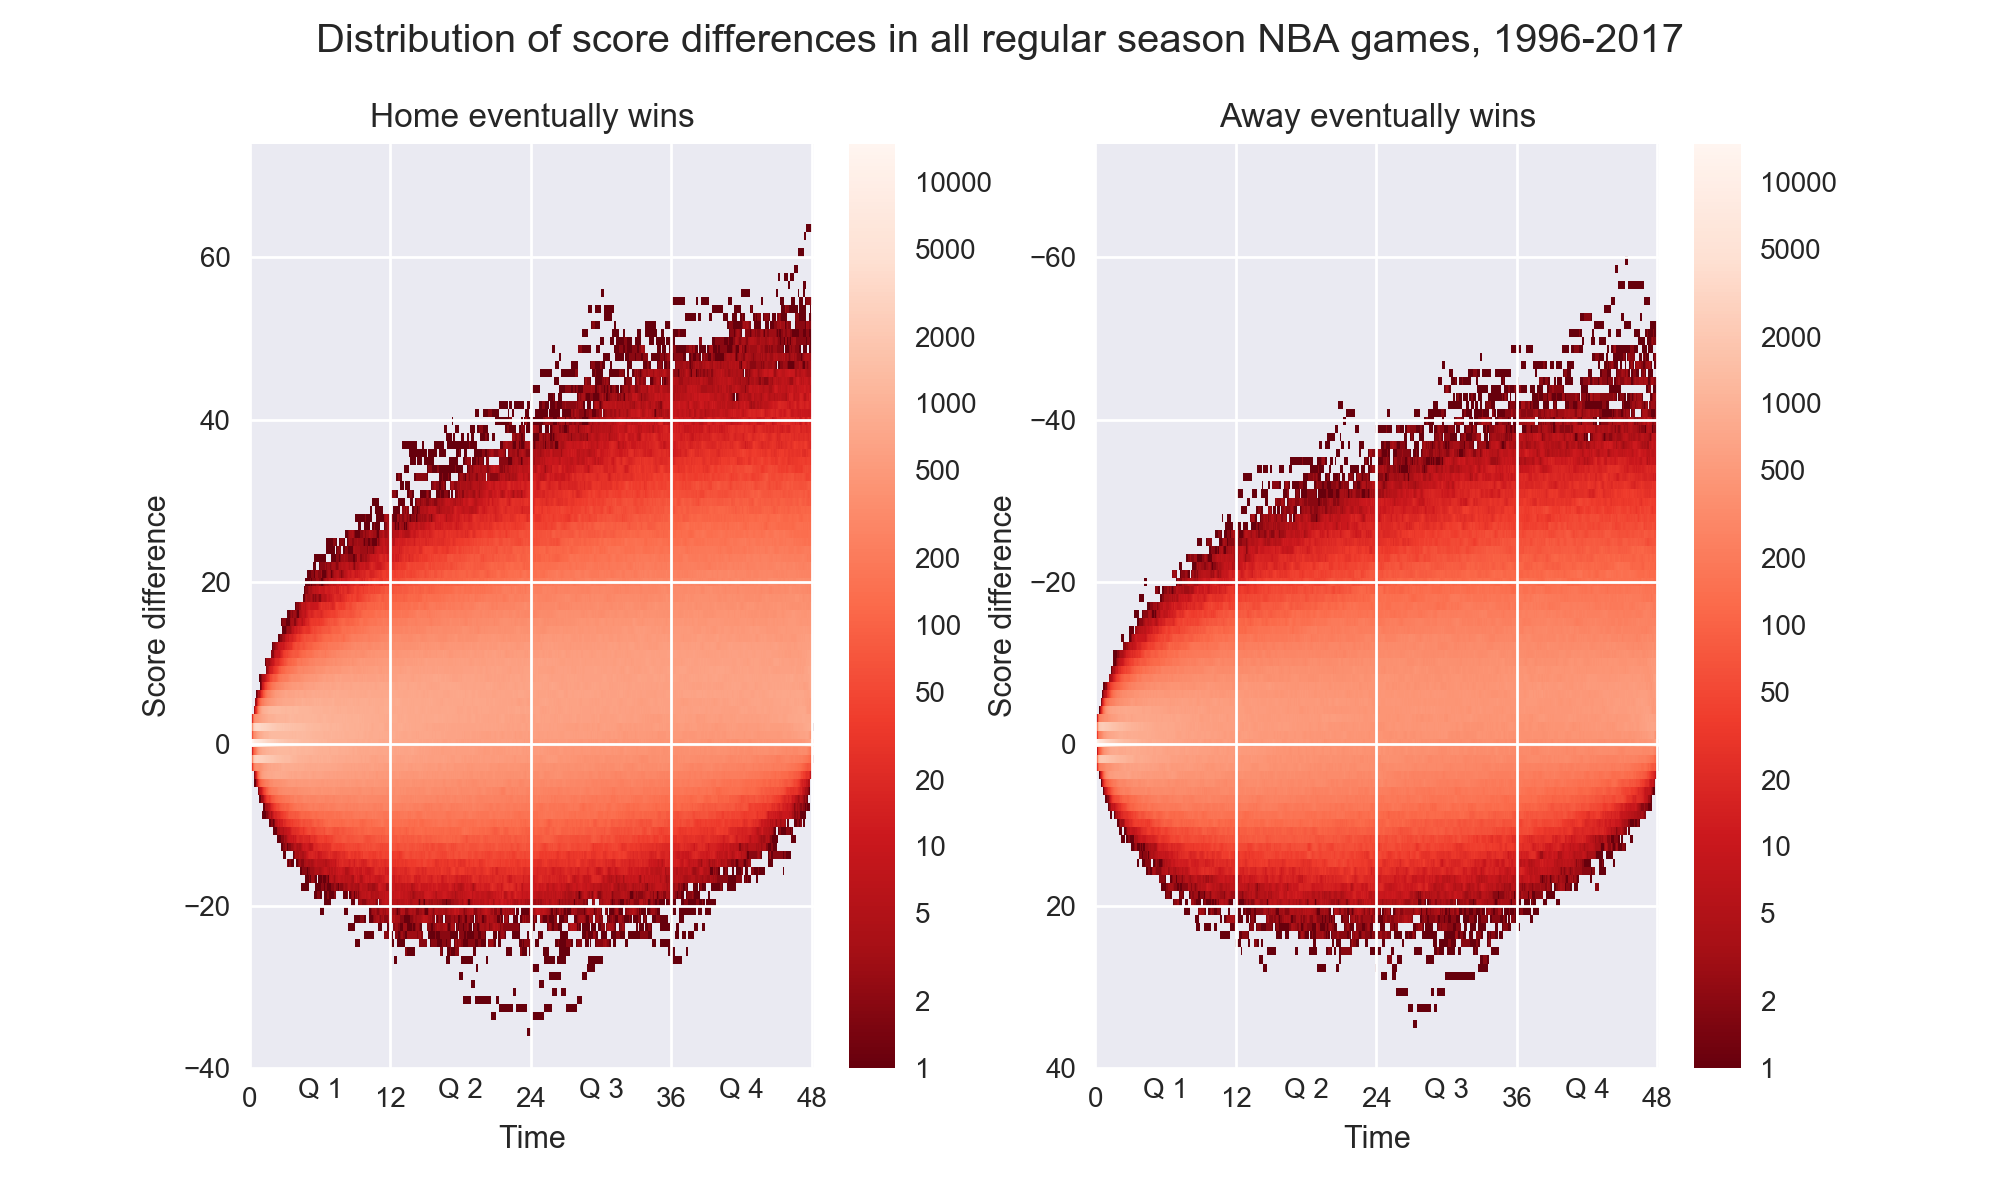

In [20]:
vmax = np.fmax(np.max(sum_all_score_counts[1]),np.max(sum_all_score_counts[-1]))
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,6))   
fig.suptitle('Distribution of score differences in all regular season NBA games, 1996-2017')
ax1.set_title("Home eventually wins")
ax2.set_title("Away eventually wins")
pc1=ax1.imshow((sum_all_score_counts[1])[60:175,:], aspect='auto',
               norm=matplotlib.colors.LogNorm(vmin=1,vmax=vmax), 
               cmap=plt.cm.Reds_r, interpolation='none', extent=[0,6000,74,-40])
pc2=ax2.imshow((sum_all_score_counts[-1])[26:141,:], aspect='auto',
               norm=matplotlib.colors.LogNorm(vmin=1,vmax=vmax), 
               cmap=plt.cm.Reds_r, interpolation='none', extent=[0,6000,40,-74])
ax1.invert_yaxis()
for ax,pc in zip([ax1,ax2],[pc1,pc2]):
    ax.set_xlim(0,total_time_show)
    c=fig.colorbar(pc, ax=ax, format=matplotlib.ticker.FormatStrFormatter('%d'))
    c.set_ticks([1,2,5,10,20,50,100,200,500,1000,2000,5000,10000])
    set_axis_params(ax)
    ax.set_xlabel("Time")
    ax.set_ylabel("Score difference")
fig.canvas.draw()
fig.savefig('score_difference_distribution_nba_1996-2017.png',dpi=fig.dpi)
fig.savefig('score_difference_distribution_nba_1996-2017.pdf')

## Show the largest home/away comebacks for each season

In [21]:
def abstime2Qtime(t):
    if t <= 2880: 
        q = t // (12*60)
        qr= t % (12*60)
        #return str(qr//60) + "'" + str(qr%60) + "'' of Q" + str(q+1)
        return "Q" + str(q+1) + ' ' + str(qr//60) + "'" + str(qr%60) + "''"

def get_game_info_link(gid):
    link_str = '<a href="http://stats.nba.com/game/#!/' + gid + '/">' \
    + ' '.join([game_info_dict[gid]['away'],'at', game_info_dict[gid]['home']]) \
    + '</a>'
    return link_str

with open('data/comebacks_1996-2016_complete.p','rb') as f:
    comebacks=cPickle.load(f)
if os.path.exists('data/game_info_dict.p'):
    with open('data/game_info_dict.p','rb') as f:
        game_info_dict=cPickle.load(f)

home_away={1:'Home',-1:'Away'}
row_list = []
for seasonstart in years:
    season = season_string(seasonstart)
    
    for outcome in[1,-1]:
        sd=sorted(comebacks[season][outcome].items())
        allscores=[s[1][0] for s in sd]
        if outcome == 1:
            bc_margin = np.min(allscores)
        else:
            bc_margin = np.max(allscores)
        game_time = {}
        for idx in np.where(allscores==bc_margin)[0]:
            for gid in sd[idx][1][1]:
                if gid not in game_time:
                    game_time[gid] = [sd[idx][0]]
                else:
                    game_time[gid].append(sd[idx][0])
        for gid in game_time:
            if len(game_time[gid])>1:
                stimes = sorted(game_time[gid])
                tstr = abstime2Qtime(stimes[0]) + ' to ' + abstime2Qtime(stimes[-1])
            else:
                tstr = 'at ' + abstime2Qtime(game_time[gid][0])
            tmp = get_info(gid)
            game_dict = {}
            game_dict.update({'Season': season,
                              'Home/Away':home_away[outcome],
                              'Comeback score': outcome*bc_margin,
                              'Game': get_game_info_link(gid), 
                              'Date': game_info_dict[gid]['time'].title(),
                              'Attendance': game_info_dict[gid]['crowd'],
                              'Time of largest score deficit': tstr})
            row_list.append(game_dict)
        
with open('data/game_info_dict.p','wb') as fid:
    cPickle.dump(game_info_dict,fid)

In [22]:
df= pd.DataFrame(row_list,columns=['Season','Home/Away','Comeback score','Game','Date','Attendance','Time of largest score deficit'])
df2=df.set_index(['Season','Home/Away'])
from IPython.display import display, HTML
pd.set_option('display.max_colwidth', -1)
with open('largest_comebacks_table.html', 'w') as fid:
    fid.write(df2.to_html(escape=False))
HTML(df2.to_html(escape=False))